In [1]:
import numpy as np
import pandas as pd
import os
import random
import librosa as libr
import librosa.display as disp
from IPython.display import Audio
from torchsummary import summary

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torchaudio
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler,Subset,DataLoader

In [3]:
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [4]:
#train_noisy_data_path = "./../data/28/noisy_trainset_28spk_wav/"
train_noisy_data_path = "./../data/28/sample/11/"
train_clean_data_path = "./../data/28/clean_trainset_28spk_wav/"
#test_noisy_data_path = "./../data/28/noisy_testset_wav/"
test_noisy_data_path = "./../data/28/sample/21/"
test_clean_data_path = "./../data/28/clean_testset_wav/"

In [5]:
config = {
    'sample_rate':48000,
    'max_duration':10,
    'n_fft':1024,
    'hop_length':512,
    'n_mels':64,
    'batch_size':128,
    'learning_rate':1e-6,
    'epochs':10
}

dev = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = torch.device(dev)  
print(f"Using {device} device")

In [6]:
device = "dev"

In [7]:
class AudioDataset(Dataset):
    def __init__(self,noisy_path,clean_path, transform=None, sample_rate=None,max_duration=None):
        
        #get file paths
        noisy_all_items = os.listdir(noisy_path)
        noisy_files = [item for item in noisy_all_items if os.path.isfile(os.path.join(noisy_path, item))]
        noisy_file_paths = [os.path.join(noisy_path, file_name) for file_name in noisy_files]
        clean_file_paths = [os.path.join(clean_path, file_name) for file_name in noisy_files]

        #initialize variables
        self.noisy_data = noisy_file_paths
        self.clean_data = clean_file_paths
        self.transform = transform
        self.sample_rate = sample_rate
        self.max_duration = max_duration
        self.num_samples = sample_rate*max_duration

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        noisy_waveform, sr = torchaudio.load(self.noisy_data[idx])  
        noisy_waveform = torch.tensor(noisy_waveform.numpy().reshape(-1))
        if noisy_waveform.shape[0] < self.num_samples:
            num_missing_samples = self.num_samples - noisy_waveform.shape[0]
            noisy_waveform = F.pad(noisy_waveform, (0, num_missing_samples))
        noisy_waveform = torch.tensor(noisy_waveform[:self.num_samples])
        if self.transform:
            noisy_waveform = self.transform(noisy_waveform)
        
        
        clean_waveform, sr = torchaudio.load(self.clean_data[idx])  
        clean_waveform = torch.tensor(clean_waveform.numpy().reshape(-1))
        if clean_waveform.shape[0] < self.num_samples:
            num_missing_samples = self.num_samples - clean_waveform.shape[0]
            clean_waveform = F.pad(torch.tensor(clean_waveform), (0, num_missing_samples))
        clean_waveform = torch.tensor(clean_waveform[:self.num_samples])
        if self.transform:
            clean_waveform = self.transform(clean_waveform)
        return noisy_waveform, clean_waveform


    def plot_waveform(self,noisy_waveform,clean_waveform):
        noisy_waveform = noisy_waveform.numpy().reshape(-1)
        clean_waveform = clean_waveform.numpy().reshape(-1)
        plt.figure(figsize=(8,5))
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.title("Noisy vs Filtered Signal - Time Domain")
        disp.waveshow(noisy_waveform,sr=self.sample_rate,label="Noisy")
        disp.waveshow(clean_waveform,sr=self.sample_rate,label="Clean")
        plt.legend()
        plt.show()
        

In [8]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config['sample_rate'],
                                                      n_fft=config['n_fft'], 
                                                      hop_length=config['hop_length'], 
                                                      n_mels=config['n_mels'])

In [9]:
train_dataset = AudioDataset(noisy_path=train_noisy_data_path,
                       clean_path=train_clean_data_path,
                       sample_rate=config['sample_rate'],
                       max_duration=config['max_duration'],
                       transform=mel_spectrogram)
test_dataset = AudioDataset(noisy_path=test_noisy_data_path,
                       clean_path=test_clean_data_path,
                       sample_rate=config['sample_rate'],
                       max_duration=config['max_duration'],
                       transform=mel_spectrogram)

In [10]:
def split_dataset(dataset, perc=0.9):
    dataset_indices = list(range(len(dataset)))
    random.shuffle(dataset_indices)
    train_indices = dataset_indices[:int(len(dataset_indices) * perc)]
    val_indices = dataset_indices[int(len(dataset_indices) * perc):]
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    return train_dataset,val_dataset

In [11]:
train_dataset, val_dataset = split_dataset(train_dataset,0.9)

In [12]:
len(train_dataset),len(val_dataset),len(test_dataset)

(372, 42, 234)

In [13]:
batch_size = 64

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
len(train_dataloader),len(val_dataloader),len(test_dataloader)

(6, 1, 4)

In [16]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 64, 938])
Shape of y: torch.Size([64, 64, 938]) torch.float32


In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self, signal_shape):
        super().__init__()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Upsample with Transposed Convolutional Layers
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        
    def forward(self, x):
        x = self.downsample(x)
        x = self.upsample(x)
        return x

In [19]:
model = NeuralNetwork(signal_shape=(64,938))
print(model)

NeuralNetwork(
  (downsample): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
)


In [20]:
learning_rate = 1e-3

In [21]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
def train_loop(dataloader, epoch, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    loss_sum = 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        #X = X.to(device)
        #y = y.to(device)
        X = X.unsqueeze(1)
        #Forwardpropagation
        pred = model(X).squeeze(1)
        loss = loss_fn(pred, y)
        #print_all_grad_fns(loss.grad_fn)
 
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #if batch % 5 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        loss_sum += loss
        #print(f"epoch: {epoch},training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_sum

In [23]:
def validate_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            #X = X.to(device)
            #y = y.to(device)
            X = X.unsqueeze(1)
            pred = model(X).squeeze(1)
            test_loss += loss_fn(pred, y)

    test_loss /= num_batches
    print(f"validation Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
epochs = 20
#model.to(device)
train_loss_history,val_loss_history = [],[]
for t in range(1,epochs+1):
    train_loss = train_loop(train_dataloader,t, model, loss_fn, optimizer,device)
    val_loss  = validate_loop(val_dataloader, model, loss_fn,device)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"epoch: {t},avg epoch train loss: {train_loss:>7f}")
    print(f"epoch: {t},avg epoch test loss: {val_loss:>7f}")

 33%|███████████████                              | 2/6 [02:39<05:20, 80.10s/it]

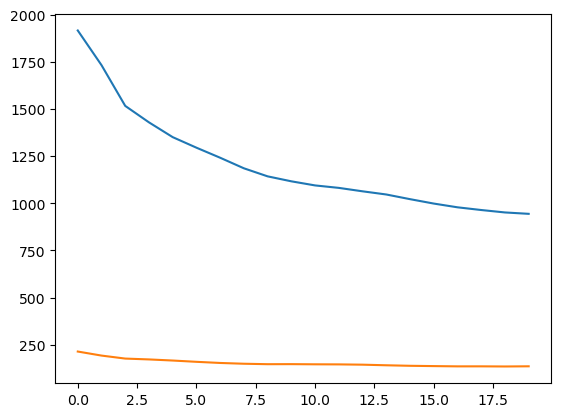

In [34]:
plt.figure()
plt.plot(train_loss_history,label='train')
plt.plot(val_loss_history,label='test')
plt.show() 

In [27]:
validate_loop(test_dataloader, model, loss_fn,device)

tensor(162.0415)

In [ ]:
import librosa as libr
import librosa.display as disp
from IPython.display import Audio

In [ ]:
test_audio,test_outputs = next(iter(test_dataloader))
outputs = model(samples).squeeze(1)

In [ ]:
plt.figure(figsize=fig_size)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Signal Waveform - Time Domain")

In [ ]:
filtered_sample_path = 'test_sample.wav'
wavfile.write(filtered_sample_path, sample_rate, filtered_signal)

disp.waveshow(signal,sr=sample_rate)
Audio(sample_file_path)

In [40]:
class WaveUNet(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        
        self.downsample = nn.Sequential(
            nn.Conv1d(input_shape[0]*input_shape[1], 64, kernel_size=3, stride=1, padding=1),
        )
        
    def forward(self, x):
        x = self.downsample(x)
        return x

In [41]:
input_shape = (64,938)
model = WaveUNet(input_shape)
model

WaveUNet(
  (downsample): Sequential(
    (0): Conv1d(60032, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  )
)

In [39]:
summary(model,input_size=(60032,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 1, 1]      34,578,496
Total params: 34,578,496
Trainable params: 34,578,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.23
Forward/backward pass size (MB): 0.00
Params size (MB): 131.91
Estimated Total Size (MB): 132.14
----------------------------------------------------------------


In [44]:
class BaseUNetModel(nn.Module):
    def __init__(self):
        super(BaseUNetModel,self).__init__()
        self.down_conv_layer_1 = nn.Sequential(
            nn.Conv2d(1, 64 , kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )        
 
        self.down_conv_layer_2 = nn.Sequential(
            nn.Conv2d(64, 128 , kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.InstanceNorm2d(128)
        ) 
    
        self.down_conv_layer_3 = nn.Sequential(
            nn.Conv2d(128, 256 , kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.InstanceNorm2d(128)
        ) 
        
        self.down_conv_layer_4 = nn.Sequential(
            nn.Conv2d(256, 256 , kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.InstanceNorm2d(128),
            nn.Dropout(0.5),   
        ) 
        
        self.up_conv_layer_1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=(4,5), stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )
        
        self.up_conv_layer_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )
        
        self.up_conv_layer_3 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=(4,5), stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(), 
        )
                
        self.upsample_layer = nn.Upsample(scale_factor=2)
        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv_layer_final = nn.Conv2d(128, 1, kernel_size=2,stride=1, padding=0)
        
        
    def forward(self,x):
        print('x', x.shape)
        enc1 = self.down_conv_layer_1(x) # [4, 64, 32, 469]
        print('1', enc1.shape)
        enc2 = self.down_conv_layer_2(enc1) # [4, 128, 16, 234]
        print('2', enc2.shape)
        enc3 = self.down_conv_layer_3(enc2) # [4, 256, 8, 117]
        print('3', enc3.shape)
        enc4 = self.down_conv_layer_4(enc3) # [4, 256, 4, 58]
        print('4', enc4.shape)
        print("only up.....")
        
        dec1 = self.up_conv_layer_1(enc4)
        print('d1', dec1.shape) # [4, 256, 8, 117]
                 
        dec13 = torch.cat((dec1, enc3), 1)
        print('d13', dec13.shape) #[4, 512, 8, 117]
        
        dec2 = self.up_conv_layer_2(dec13)
        print('d2', dec2.shape) # [4, 128, 16, 234]
                 
        dec22 = torch.cat((dec2, enc2), 1)
        print('d22', dec22.shape) #[4, 256, 16, 234]
        
        dec3 = self.up_conv_layer_3(dec22)
        print('d3', dec3.shape) # [4, 256, 16, 234]
                 
        dec31 = torch.cat((dec3, enc1), 1)
        print('d31', dec31.shape) #[4, 256, 16, 234]
        
        final = self.upsample_layer(dec31)
        final = self.zero_pad(final)
        final = self.conv_layer_final(final)

        print(final.shape)
        return final

In [45]:
WaveUNet4()

WaveUNet4(
  (downsample1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (downsample2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (downsample3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (downsample4): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (middle): Sequential(
    (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,

In [52]:
summary(WaveUNet4(),input_size=(1,60038))

RuntimeError: Given groups=1, weight of size [128, 384, 3], expected input[2, 128, 7504] to have 384 channels, but got 128 channels instead